##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 基本训练循环

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/guide/basic_training_loops"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a> </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/basic_training_loops.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a> </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/basic_training_loops.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a> </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/guide/basic_training_loops.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a> </td>
</table>

在前面的教程里，您已经了解了[tensors](./tensor.ipynb), [variables](./variable.ipynb), [gradient tape](autodiff.ipynb), 和[modules](./intro_to_modules.ipynb)。在这篇教程，您将把它们放在一起训练模型。

此外，TensorFlow 还包括 [tf.Keras API](https://tensorflow.google.cn/guide/keras/overview)，这是一种高级神经网络 API，可提供有用的抽象来减少样板。但是，在本指南中，您将使用基本类。

## 创建

In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

2022-12-14 20:11:29.211963: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:11:29.212049: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:11:29.212057: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## 解决机器学习问题

解决一个机器学习问题通常包含以下步骤：

- 获得训练数据。
- 定义模型。
- 定义损失函数。
- 遍历训练数据，从目标值计算损失。
- 计算该损失的梯度，并使用*optimizer*调整变量以适合数据。
- 计算结果。

为了便于说明，在本指南中，您将开发一个简单的线性模型, $f(x) = x * W + b$, 其中包含两个变量: $W$ (权重) 和 $b$ (偏差)。

这是最基本的机器学习问题：给定 $x$ 和 $y$，尝试通过[简单的线性回归](https://en.wikipedia.org/wiki/Linear_regression#Simple_and_multiple_linear_regression)来找到直线的斜率和偏移量。

## 数据

监督学习使用*输入*（通常表示为 *x*）和*输出*（表示为 *y*，通常称为*标签*）。目标是从成对的输入和输出中学习，以便您可以根据输入预测输出的值。

TensorFlow中几乎每个输入数据都是由张量表示，并且通常是向量。监督学习中，输出(即想到预测值)同样是个张量。

下面是通过将高斯（正态）噪声添加到直线上的点而合成的一些数据。

In [3]:
# The actual line
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 201

# A vector of random x values
x = tf.linspace(-2,2, NUM_EXAMPLES)
x = tf.cast(x, tf.float32)

def f(x):
  return x * TRUE_W + TRUE_B

# Generate some noise
noise = tf.random.normal(shape=[NUM_EXAMPLES])

# Calculate y
y = f(x) + noise

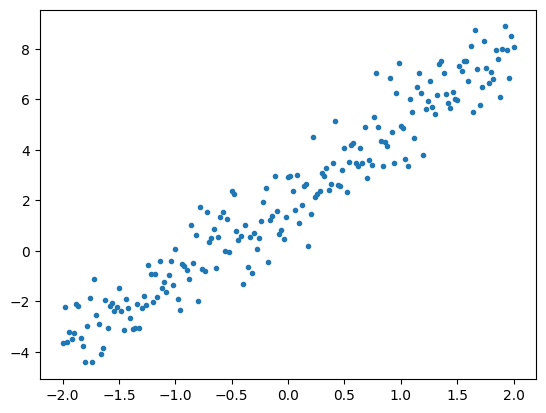

In [4]:
# Plot all the data
plt.plot(x, y, '.')
plt.show()

张量通常以 *batches* 的形式聚集在一起，或者是成组的输入和输出堆叠在一起。批处理能够对训练过程带来一些好处，并且可以与加速器和矢量化计算很好地配合使用。给定此数据集的大小，您可以将整个数据集视为一个批次。

## 定义模型

使用 `tf.Variable` 代表模型中的所有权重。`tf.Variable` 能够存储值，并根据需要以张量形式提供它。详情请见 [variable guide](./variable.ipynb)。

使用 `tf.Module` 封装变量和计算。您可以使用任何Python对象，但是通过这种方式可以轻松保存它。

这里，您可以定义 *w* 和 *b* 为变量。

In [5]:
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.w * x + self.b

model = MyModel()

# List the variables tf.modules's built-in variable aggregation.
print("Variables:", model.variables)

# Verify the model works
assert model(3.0).numpy() == 15.0

Variables: (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>)


初始变量在此处以固定方式设置，但 Keras 提供了您可以与或不与 Keras 其他部分一起使用的许多[初始值设定项](https://tensorflow.google.cn/api_docs/python/tf/keras/initializers)。

### 定义损失函数

损失函数衡量给定输入的模型输出与目标输出的匹配程度。目的是在训练过程中尽量减少这种差异。定义标准的L2损失，也称为“均方误差”:

In [6]:
# This computes a single loss value for an entire batch
def loss(target_y, predicted_y):
  return tf.reduce_mean(tf.square(target_y - predicted_y))

在训练模型之前，您可以可视化损失值。使用红色绘制模型的预测值，使用蓝色绘制训练数据。

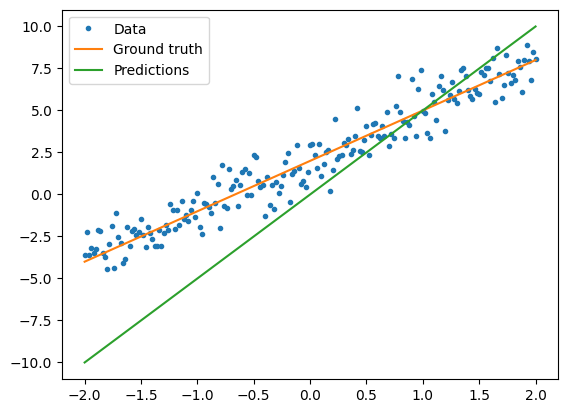

Current loss: 10.730574


In [7]:
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(y, model(x)).numpy())

### 定义训练循环

训练循环按顺序重复执行以下任务：

- 发送一批输入值，通过模型生成输出值
- 通过比较输出值与输出（标签），来计算损失值
- 使用梯度带(GradientTape)找到梯度值
- 使用这些梯度优化变量

这个例子中，您可以使用 [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)训练数据。

`tf.keras.optimizers`中有许多梯度下降的变量。但是本着搭建的第一原则，您将在这里 借助`tf.GradientTape`的自动微分和`tf.assign_sub`的递减值（结合了`tf.assign`和`tf.sub`）自己实现基本数学：

In [8]:
# Given a callable model, inputs, outputs, and a learning rate...
def train(model, x, y, learning_rate):

  with tf.GradientTape() as t:
    # Trainable variables are automatically tracked by GradientTape
    current_loss = loss(y, model(x))

  # Use GradientTape to calculate the gradients with respect to W and b
  dw, db = t.gradient(current_loss, [model.w, model.b])

  # Subtract the gradient scaled by the learning rate
  model.w.assign_sub(learning_rate * dw)
  model.b.assign_sub(learning_rate * db)

要查看训练，您可以通过训练循环发送同一批次的 *x* 和 *y*，并观察 `W` 和 `b` 如何变化。

In [9]:
model = MyModel()

# Collect the history of W-values and b-values to plot later
weights = []
biases = []
epochs = range(10)

# Define a training loop
def report(model, loss):
  return f"W = {model.w.numpy():1.2f}, b = {model.b.numpy():1.2f}, loss={loss:2.5f}"


def training_loop(model, x, y):

  for epoch in epochs:
    # Update the model with the single giant batch
    train(model, x, y, learning_rate=0.1)

    # Track this before I update
    weights.append(model.w.numpy())
    biases.append(model.b.numpy())
    current_loss = loss(y, model(x))

    print(f"Epoch {epoch:2d}:")
    print("    ", report(model, current_loss))

进行训练

In [10]:
current_loss = loss(y, model(x))

print(f"Starting:")
print("    ", report(model, current_loss))

training_loop(model, x, y)

Starting:
     W = 5.00, b = 0.00, loss=10.73057


Epoch  0:
     W = 4.45, b = 0.41, loss=6.58578
Epoch  1:
     W = 4.05, b = 0.74, loss=4.21202
Epoch  2:
     W = 3.75, b = 1.00, loss=2.84173
Epoch  3:
     W = 3.54, b = 1.21, loss=2.04423
Epoch  4:
     W = 3.38, b = 1.38, loss=1.57628
Epoch  5:
     W = 3.27, b = 1.51, loss=1.29945
Epoch  6:
     W = 3.18, b = 1.62, loss=1.13437
Epoch  7:
     W = 3.12, b = 1.71, loss=1.03518
Epoch  8:
     W = 3.08, b = 1.78, loss=0.97515
Epoch  9:
     W = 3.04, b = 1.83, loss=0.93857


下面是权重随时间的演变：

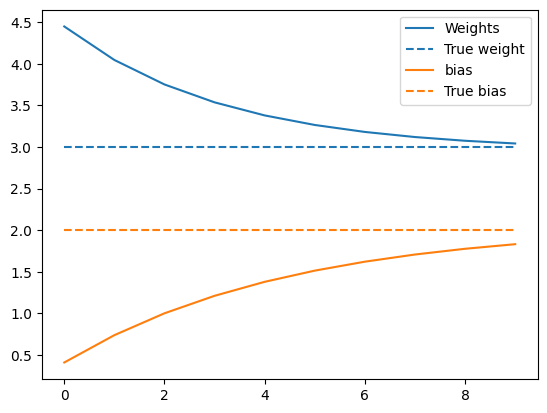

In [11]:
plt.plot(epochs, weights, label='Weights', color=colors[0])
plt.plot(epochs, [TRUE_W] * len(epochs), '--',
         label = "True weight", color=colors[0])

plt.plot(epochs, biases, label='bias', color=colors[1])
plt.plot(epochs, [TRUE_B] * len(epochs), "--",
         label="True bias", color=colors[1])

plt.legend()
plt.show()

呈现训练的模型的性能

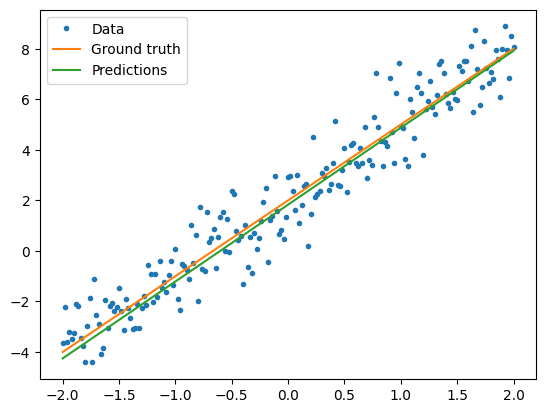

Current loss: 0.938567


In [12]:
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(model(x), y).numpy())

## 使用Keras完成相同的解决方案

将上面的代码与Keras中的等效代码进行对比很有用。

如果您将`tf.keras.Model`子类化，则定义模型与其看起来完全相同。请记住，Keras模型最终从模块继承。

In [13]:
class MyModelKeras(tf.keras.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def call(self, x):
    return self.w * x + self.b

keras_model = MyModelKeras()

# Reuse the training loop with a Keras model
training_loop(keras_model, x, y)

# You can also save a checkpoint using Keras's built-in support
keras_model.save_weights("my_checkpoint")

Epoch  0:
     W = 4.45, b = 0.41, loss=6.58578
Epoch  1:
     W = 4.05, b = 0.74, loss=4.21202
Epoch  2:
     W = 3.75, b = 1.00, loss=2.84173
Epoch  3:
     W = 3.54, b = 1.21, loss=2.04423
Epoch  4:
     W = 3.38, b = 1.38, loss=1.57628
Epoch  5:
     W = 3.27, b = 1.51, loss=1.29945
Epoch  6:
     W = 3.18, b = 1.62, loss=1.13437
Epoch  7:
     W = 3.12, b = 1.71, loss=1.03518
Epoch  8:
     W = 3.08, b = 1.78, loss=0.97515
Epoch  9:
     W = 3.04, b = 1.83, loss=0.93857


您可以使用Keras的内置功能作为捷径，而不必在每次创建模型时都编写新的训练循环。当您不想编写或调试Python训练循环时，这很有用。

如果您使用Keras，您将会需要使用 `model.compile()` 去设置参数, 使用`model.fit()` 进行训练。借助Keras实现L2损失和梯度下降需要的代码量更少，就像一个捷径。Keras损失和优化器也可以在这些便利功能之外使用，而前面的示例也可以使用它们。

In [14]:
keras_model = MyModelKeras()

# compile sets the training parameters
keras_model.compile(
    # By default, fit() uses tf.function().  You can
    # turn that off for debugging, but it is on now.
    run_eagerly=False,

    # Using a built-in optimizer, configuring as an object
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),

    # Keras comes with built-in MSE error
    # However, you could use the loss function
    # defined above
    loss=tf.keras.losses.mean_squared_error,
)

Keras`fit`期望批处理数据或完整的数据集作为NumPy数组。 NumPy数组分为多个批次，默认批次大小为32。

这一案例中，为了匹配手写训练循环，您应该以大小为1000的单批次传递x。

In [15]:
print(x.shape[0])
keras_model.fit(x, y, epochs=10, batch_size=1000)

201
Epoch 1/10


1/1 [==============================] - ETA: 0s - loss: 10.7306

1/1 [==============================] - 0s 469ms/step - loss: 10.7306


Epoch 2/10


1/1 [==============================] - ETA: 0s - loss: 6.5858

1/1 [==============================] - 0s 5ms/step - loss: 6.5858


Epoch 3/10


1/1 [==============================] - ETA: 0s - loss: 4.2120

1/1 [==============================] - 0s 4ms/step - loss: 4.2120


Epoch 4/10


1/1 [==============================] - ETA: 0s - loss: 2.8417

1/1 [==============================] - 0s 4ms/step - loss: 2.8417


Epoch 5/10


1/1 [==============================] - ETA: 0s - loss: 2.0442

1/1 [==============================] - 0s 4ms/step - loss: 2.0442


Epoch 6/10


1/1 [==============================] - ETA: 0s - loss: 1.5763

1/1 [==============================] - 0s 4ms/step - loss: 1.5763


Epoch 7/10


1/1 [==============================] - ETA: 0s - loss: 1.2994

1/1 [==============================] - 0s 4ms/step - loss: 1.2994


Epoch 8/10


1/1 [==============================] - ETA: 0s - loss: 1.1344

1/1 [==============================] - 0s 4ms/step - loss: 1.1344


Epoch 9/10


1/1 [==============================] - ETA: 0s - loss: 1.0352

1/1 [==============================] - 0s 4ms/step - loss: 1.0352


Epoch 10/10


1/1 [==============================] - ETA: 0s - loss: 0.9751

1/1 [==============================] - 0s 4ms/step - loss: 0.9751


请注意，Keras会在训练后而不是之前打印出损失，因此第一次损失会显得较低。否则，这表明本质上相同的训练效果。

## 下一步

在这篇引导中，您已经看到怎样使用tensors, variables, modules, 和gradient tape去构建并训练模型，也进一步了解到这些是如何与Keras对应的。

但是，这是一个极其简单的问题。有关更实用的介绍，请参阅[自定义训练演示](../tutorials/customization/custom_training_walkthrough.ipynb)。

有关使用内置 Keras 训练循环的更多信息，请参阅[本指南](https://tensorflow.google.cn/guide/keras/train_and_evaluate)。有关训练循环和 Keras 的更多信息，请参阅[本指南](https://tensorflow.google.cn/guide/keras/writing_a_training_loop_from_scratch)。有关编写自定义分布式训练循环的信息，请参阅[本指南](distributed_training.ipynb#using_tfdistributestrategy_with_basic_training_loops_loops)。